In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
import gensim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report, f1_score


#text is already cleaned.
#assign cleaned data to these variables.
train_data_path = 'cleaned_data/cleaned_train_data_for_subtask1.csv'
test_data_path = 'cleaned_data/cleaned_test_data_for_subtask1.csv'
#read files.
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

del train_data['#1_tweetid']
del train_data['#2_tweet']
del test_data['#1_tweetid']
del test_data['#2_tweet']

print("Train set:"% train_data.columns, train_data.shape, len(train_data)) 
print("Test set:"% test_data.columns, test_data.shape, len(test_data)) 



C:\Users\Mena\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Train set: (21000, 2) 21000
Test set: (5000, 2) 5000


In [2]:
#add numerical representation.
classes = train_data['#3_country_label'].unique().tolist()
classes_dic = {}
for i, class_name in enumerate(classes):
    classes_dic[class_name] = i

def find_class_id_from_name(class_name):
    return classes_dic[class_name]

train_data['#4class_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['#4class_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

display(train_data)
display(test_data)



{'Egypt': 0,
 'Iraq': 1,
 'Saudi_Arabia': 2,
 'Mauritania': 3,
 'Algeria': 4,
 'Syria': 5,
 'Oman': 6,
 'Tunisia': 7,
 'Lebanon': 8,
 'Morocco': 9,
 'Djibouti': 10,
 'United_Arab_Emirates': 11,
 'Kuwait': 12,
 'Libya': 13,
 'Bahrain': 14,
 'Qatar': 15,
 'Yemen': 16,
 'Palestine': 17,
 'Jordan': 18,
 'Somalia': 19,
 'Sudan': 20}

,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حلوهhello 12 حاجه حلوه حلوه اكيد,0
1,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا و يغشو...,1
2,Saudi_Arabia,ابشر طال عمرك,2
3,Mauritania,منطق انا و الغريب علي ابن عمي و انا و الغريب و...,3
4,Algeria,شهرين و تروح و الباقي غير صيف ملينا,4
...,...,...,...
20995,Algeria,هذا اناني و نافخ روحو,4
20996,Iraq,ابا اتعلم ارسم,1
20997,Iraq,كلمه و قح شكلك توك الا متعلمتنها كثير تقوليها ...,1
20998,Egypt,ربنا ما يوريك الناس الدحيحه لما يتروشنوا,0


,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,قولنا اون لاين لا ياعلي اون لاين لا,0
1,Oman,ه بايخه ه,6
2,Lebanon,ربنا يخليك يادوك و لك المثل,8
3,Syria,اوامر ملكيه ياشباب اي و احد فيكم عنده شي يذكره...,5
4,Libya,شد عالخط حتي هيا اكويسه,13
...,...,...,...
4995,Libya,و في الشتاء مستحيل يقب,13
4996,Libya,اكيد حبيبتي و انت في كيفك و كيف طيبه قلبك,13
4997,Jordan,يسعد صباح الناس رايقه,18
4998,Morocco,فرحتهم فيها ياتقبرني,9


In [3]:
#check no. of tweets for each country.
df_majority_minority = train_data.groupby(['#3_country_label','#4class_id']).size().to_frame('count').reset_index()
df_majority_minority.sort_values(by=['count'], inplace=True, ascending=False)
display(df_majority_minority)

,#3_country_label,#4class_id,count
3,Egypt,0,4283
4,Iraq,1,2729
14,Saudi_Arabia,2,2140
0,Algeria,4,1809
11,Oman,6,1501
17,Syria,5,1287
8,Libya,13,1286
18,Tunisia,7,859
10,Morocco,9,858
7,Lebanon,8,644


In [4]:
#get major country.
major_country = df_majority_minority.iloc[0]['#3_country_label']
major_samples_no = df_majority_minority.iloc[0]['count']
print("major country is", major_country ,"with: ", major_samples_no, "samples.")

major country is Egypt with:  4283 samples.


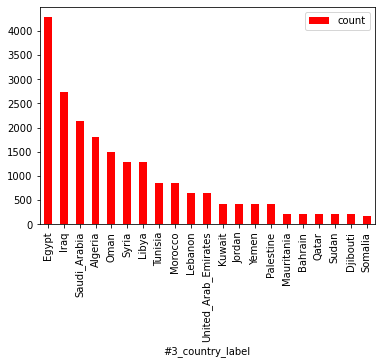

In [5]:
df_majority_minority.plot(kind='bar',x='#3_country_label',y='count',color='red')
plt.show()

In [6]:
#remove empty tweets.
#    column_name = "#2_tweet_clean"
#   df = train_data

def remove_empty_tweets(df, column_name):
    nan_value = float("NaN")

    df.replace("", nan_value, inplace=True)

    df.dropna(subset = [column_name], inplace=True)

    return df

remove_empty_tweets(train_data, "#2_tweet_clean")


,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حلوهhello 12 حاجه حلوه حلوه اكيد,0
1,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا و يغشو...,1
2,Saudi_Arabia,ابشر طال عمرك,2
3,Mauritania,منطق انا و الغريب علي ابن عمي و انا و الغريب و...,3
4,Algeria,شهرين و تروح و الباقي غير صيف ملينا,4
...,...,...,...
20995,Algeria,هذا اناني و نافخ روحو,4
20996,Iraq,ابا اتعلم ارسم,1
20997,Iraq,كلمه و قح شكلك توك الا متعلمتنها كثير تقوليها ...,1
20998,Egypt,ربنا ما يوريك الناس الدحيحه لما يتروشنوا,0


In [7]:
display(train_data['#2_tweet_clean'][5])
display(test_data['#2_tweet_clean'][6])

'يابنتي و اله ما حد متغاظ و لا مفروس منك و لا بيحسدك انتي عره اساسا'

'لا مين انت ه '

In [8]:
#remove arabic formal clitics from tweets.
stop_words_file = open('formal clitics stop words.txt','r',encoding="utf8")
stop_words_list = [line.strip() for line in stop_words_file]

def remove_stopwords(text):
    text_tokens = text.strip().split(" ")
    tokens_filtered= [word for word in text_tokens if not word in stop_words_list]
    return (" ").join(tokens_filtered)

train_data['#2_tweet_clean']= train_data['#2_tweet_clean'].apply(remove_stopwords)
    
test_data['#2_tweet_clean']= test_data['#2_tweet_clean'].apply(remove_stopwords)
    
    
display(train_data['#2_tweet_clean'][5])
display(test_data['#2_tweet_clean'][6])

'يابنتي اله حد متغاظ مفروس منك بيحسدك انتي عره اساسا'

'مين انت'

In [9]:
#remove duplicate keywords from tweets.
from collections import OrderedDict
display(train_data)

#df_column_name = train_data['#2_tweet_clean']
def remove_duplicate_words(df_column_name):
    df_column_name = (df_column_name.str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))
    return df_column_name

train_data['#2_tweet_clean'] = remove_duplicate_words(train_data['#2_tweet_clean'])
display(train_data)

,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حلوهhello 12 حاجه حلوه حلوه اكيد,0
1,Iraq,عم بشتغلوا لشعب الاميركي يكذبوا يغشوا يسرقوا ي...,1
2,Saudi_Arabia,ابشر طال عمرك,2
3,Mauritania,منطق انا الغريب ابن عمي انا الغريب ابن عمي اخو...,3
4,Algeria,شهرين تروح الباقي صيف ملينا,4
...,...,...,...
20995,Algeria,اناني نافخ روحو,4
20996,Iraq,ابا اتعلم ارسم,1
20997,Iraq,كلمه قح شكلك توك متعلمتنها كثير تقوليها بس تعر...,1
20998,Egypt,ربنا يوريك الناس الدحيحه يتروشنوا,0


,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حلوهhello 12 حاجه حلوه اكيد,0
1,Iraq,عم بشتغلوا لشعب الاميركي يكذبوا يغشوا يسرقوا ي...,1
2,Saudi_Arabia,ابشر طال عمرك,2
3,Mauritania,منطق انا الغريب ابن عمي اخويا قطع العلاقات قطر...,3
4,Algeria,شهرين تروح الباقي صيف ملينا,4
...,...,...,...
20995,Algeria,اناني نافخ روحو,4
20996,Iraq,ابا اتعلم ارسم,1
20997,Iraq,كلمه قح شكلك توك متعلمتنها كثير تقوليها بس تعر...,1
20998,Egypt,ربنا يوريك الناس الدحيحه يتروشنوا,0


In [10]:
#remove rare words.

#df_column_name = train_data['#2_tweet_clean'] 
#unique_count = 3
def remove_rare_words(df_column_name, unique_count):
    all_ = [x for y in df_column_name for x in y.split(' ') ]
    a,b = np.unique(all_, return_counts = True)
    to_remove = a[b<unique_count]
    print("words removed: ", len(to_remove))
    return [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)]) for y in df_column_name]
    
train_data['#2_tweet_clean']= remove_rare_words(train_data['#2_tweet_clean'], 10)
#display(train_data['#2_tweet_clean'])

words removed:  43751


In [11]:
#remove english letters and numbers.
print("remove eng")
#df_column_name = train_data['#2_tweet_clean']
def remove_eng_letters_numbers(df_column_name):
    return df_column_name.str.replace("[a-zA-Z0-9]","")

train_data['#2_tweet_clean'] = remove_eng_letters_numbers(train_data['#2_tweet_clean'])

remove eng


In [12]:
#remove words that are repeated in 95% of the words.
display(train_data)

#df_column_name = train_data['#2_tweet_clean']
#common_perecentage = 0.95
def remove_common_words(df_column_name, common_perecentage): 
    words_count = len([x for y in df_column_name for x in y.split(' ') ])
    print(words_count)
    minimum_words = words_count * common_perecentage
    print(minimum_words)
    df = pd.Series(df_column_name)
    return df.groupby((df.shift() != df).cumsum())\
                                 .filter(lambda x: len(x) < int(minimum_words))
    

train_data['#2_tweet_clean'] = remove_common_words(train_data['#2_tweet_clean'], 0.95)


,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حاجه حلوه اكيد,0
1,Iraq,عم,1
2,Saudi_Arabia,طال عمرك,2
3,Mauritania,انا الغريب ابن عمي اخويا قطر موريتانيا,3
4,Algeria,شهرين تروح الباقي,4
...,...,...,...
20995,Algeria,,4
20996,Iraq,ابا,1
20997,Iraq,كلمه شكلك كثير بس تعرفي معناها نفسك تكوني فيك,1
20998,Egypt,ربنا الناس,0


72548
68920.59999999999


In [13]:
#balance data.
display(train_data)
#smote = SMOTE(random_state = 101)
#X_tr, y_tr = smote.fit_resample(X_train, y_train) #Creating a new Oversampling Data Frame
#display(y_tr.shape)
#display(X_tr.shape)

,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حاجه حلوه اكيد,0
1,Iraq,عم,1
2,Saudi_Arabia,طال عمرك,2
3,Mauritania,انا الغريب ابن عمي اخويا قطر موريتانيا,3
4,Algeria,شهرين تروح الباقي,4
...,...,...,...
20995,Algeria,,4
20996,Iraq,ابا,1
20997,Iraq,كلمه شكلك كثير بس تعرفي معناها نفسك تكوني فيك,1
20998,Egypt,ربنا الناس,0


In [14]:
#prepare train and test data.
X_train = train_data['#2_tweet_clean']
y_train = train_data['#4class_id']
X_test = test_data['#2_tweet_clean']
y_test = test_data['#4class_id']


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_no = 50000
sql_len = 250
dim = 100

tokenizer = Tokenizer(num_words=max_no, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

tokenizer = Tokenizer(num_words=max_no, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(X_test.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2184 unique tokens.
Found 16521 unique tokens.


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


X_tr = tokenizer.texts_to_sequences(X_train.values)
X_tr = pad_sequences(X_tr, maxlen=sql_len)
print('Shape of data tensor:', X_tr.shape)

X_te = tokenizer.texts_to_sequences(X_test.values)
X_te = pad_sequences(X_te, maxlen=sql_len)
print('Shape of data tensor:', X_te.shape)


Shape of data tensor: (21000, 250)
Shape of data tensor: (5000, 250)


In [17]:
Y_tr = pd.get_dummies(y_train).values
print('Shape of label tensor:', Y_tr.shape)

Y_te = pd.get_dummies(y_test).values
print('Shape of label tensor:', Y_te.shape)

Shape of label tensor: (21000, 21)
Shape of label tensor: (5000, 21)


In [ ]:
import keras
import tensorflow
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
#import tensorsflow_addons as tfa
model = keras.Sequential()
model.add(Embedding(max_no, dim, input_shape=(sql_len,)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_tr, Y_tr, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Using TensorFlow backend.



Train on 18900 samples, validate on 2100 samples
Epoch 1/20
18900/18900 [==============================] - 164s 9ms/step - loss: 2.5958 - accuracy: 0.2239 - val_loss: 2.4968 - val_accuracy: 0.2652
Epoch 2/20
18900/18900 [==============================] - 164s 9ms/step - loss: 2.3737 - accuracy: 0.3089 - val_loss: 2.3645 - val_accuracy: 0.3067
Epoch 3/20
18900/18900 [==============================] - 181s 10ms/step - loss: 2.1841 - accuracy: 0.3653 - val_loss: 2.2907 - val_accuracy: 0.3229
Epoch 4/20
18900/18900 [==============================] - 179s 9ms/step - loss: 2.0593 - accuracy: 0.3985 - val_loss: 2.2969 - val_accuracy: 0.3314
Epoch 5/20
18900/18900 [==============================] - 181s 10ms/step - loss: 2.0623 - accuracy: 0.4032 - val_loss: 2.3035 - val_accuracy: 0.3310
Epoch 6/20
 2816/18900 [===>..........................] - ETA: 2:30 - loss: 1.9330 - accuracy: 0.4329

In [ ]:
y_pred= model.predict(X_te)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_data['#4class_id']
Y_te = pd.get_dummies(y_test).values

Y_te = np.argmax(Y_te, axis=1)
print(f1_score(Y_te, y_pred, average='macro'))
